In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Flatten, Conv2D, MaxPool2D, LSTM, Dropout, Dense, TimeDistributed, Input
from keras.models import Model
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#load in the training data and labels
X_train = np.load("/content/drive/My Drive/data/X_train.npy")
Y_train = np.load("/content/drive/My Drive/data/Y_train.npy")

#load in the validation data and labels
X_val = np.load("/content/drive/My Drive/data/X_val.npy")
Y_val = np.load("/content/drive/My Drive/data/Y_val.npy")

X_test = np.load("/content/drive/My Drive/data/X_test.npy")
Y_test = np.load("/content/drive/My Drive/data/Y_test.npy")

In [4]:
batch_size = 128
epochs = 10
image_size = X_train.shape[1:]
output_size = 6
image_height = 161
image_width = 99

print(image_size)

(161, 99, 1)


In [0]:
X_train_scaled = X_train * (1 / 255)
X_val_scaled = X_val * (1  / 255)
X_test_scaled = X_test * (1 / 255)

In [0]:
#remove the channel dimension for the recurrent neural networks 
X_train_scaled = np.squeeze(X_train_scaled,axis=3)
X_val_scaled = np.squeeze(X_val_scaled,axis=3)
X_test_scaled = np.squeeze(X_test_scaled,axis=3)

In [7]:
X_train_scaled.shape[1:]
X_val_scaled.shape[1:]
X_val_scaled.shape[1:]

(161, 99)

In [8]:
Y_train = to_categorical(Y_train,num_classes=output_size)
Y_val = to_categorical(Y_val,num_classes=output_size)
Y_test = to_categorical(Y_test,num_classes=output_size)

Y_train[1]

array([0., 0., 0., 0., 1., 0.], dtype=float32)

In [0]:
def create_recurrent_model(input_shape=(161,99),num_classes=output_size):

  X_input = Input(input_shape)

  #first LSTM layer
  X = LSTM(512,input_shape=input_shape, return_sequences=True)(X_input)
  X = LSTM(256, return_sequences=True)(X)
  X = LSTM(512,return_sequences=True)(X)
  X = Dropout(0.5)(X)

  #reduce the dimensions
  X = TimeDistributed(Dense(256,activation="relu"))(X)
  X = TimeDistributed(Dense(128,activation="relu"))(X)
  X = TimeDistributed(Dense(64,activation="relu"))(X)
  X = TimeDistributed(Dense(32,activation="relu"))(X)
  X = Dropout(0.5)(X)
  X = Flatten()(X)
  X  = Dense(num_classes,activation="softmax")(X)

  model = Model(inputs=X_input,outputs=X,name="RNN_Classifier")

  return model

In [15]:
model = create_recurrent_model()
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["acc"])
model.summary()

Model: "RNN_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 161, 99)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 161, 512)          1253376   
_________________________________________________________________
lstm_4 (LSTM)                (None, 161, 256)          787456    
_________________________________________________________________
lstm_5 (LSTM)                (None, 161, 512)          1574912   
_________________________________________________________________
dropout_2 (Dropout)          (None, 161, 512)          0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 161, 256)          131328    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 161, 128)       

In [16]:
history = model.fit(X_train_scaled,Y_train,batch_size=batch_size,epochs=30,verbose=1,validation_data=(X_val_scaled,Y_val))

Train on 10228 samples, validate on 2557 samples
Epoch 1/30
10228/10228 [==============================] - 107s 10ms/step - loss: 1.5481 - acc: 0.3592 - val_loss: 1.2894 - val_acc: 0.4955
Epoch 2/30
10228/10228 [==============================] - 104s 10ms/step - loss: 1.1354 - acc: 0.5802 - val_loss: 0.9786 - val_acc: 0.6465
Epoch 3/30
10228/10228 [==============================] - 104s 10ms/step - loss: 0.9368 - acc: 0.6674 - val_loss: 0.8733 - val_acc: 0.6903
Epoch 4/30
10228/10228 [==============================] - 104s 10ms/step - loss: 0.8111 - acc: 0.7215 - val_loss: 0.7481 - val_acc: 0.7395
Epoch 5/30
10228/10228 [==============================] - 104s 10ms/step - loss: 0.7437 - acc: 0.7393 - val_loss: 0.6891 - val_acc: 0.7634
Epoch 6/30
10228/10228 [==============================] - 104s 10ms/step - loss: 0.6868 - acc: 0.7621 - val_loss: 0.6034 - val_acc: 0.7986
Epoch 7/30
10228/10228 [==============================] - 105s 10ms/step - loss: 0.6104 - acc: 0.7930 - val_loss: 0.6

In [17]:
scores = model.evaluate(X_test_scaled,Y_test,verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.27984484082204536
Test accuracy: 0.9092188599997217


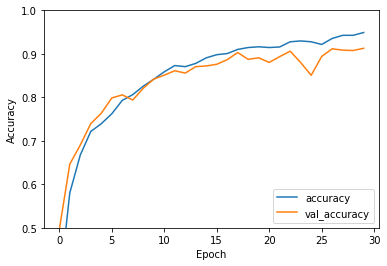

In [18]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test_scaled,  Y_test, verbose=2)